In [9]:
# load data
from data.data_collection import load_credit_data
from data.data_preparation import *
from feature_preparation.feature_selection import drop_correlated_features
from model_selection.model_training import get_train_test_data
from feature_preparation.feature_engineering import get_scaler, scale_data,create_total_delays, create_payment_consistency

In [10]:
def perform_engineering(data):
    """
    Apply feature engineering and track newly created continuous features.

    Parameters
    ----------
    data : pd.DataFrame
        Input dataset.

    Returns
    -------
    data_with_engineering : pd.DataFrame
        Dataset with engineered features added.
    added_continuous_columns : list of str
        List of newly created continuous features.
    """
    added_continuous_columns = []

    data_with_engineering = data.copy()
    data_with_engineering = create_payment_consistency(data_with_engineering) # moving forward this should be a tuple that will return the data and column name so that silent errors wont pass
    data_with_engineering = create_total_delays(data_with_engineering)

    # Track only continuous features
    added_continuous_columns.append("payment_consistency")

    return data_with_engineering, added_continuous_columns

def add_continuous_columns(original_continuous_columns, columns_to_add):
    """
    Add new continuous columns to an existing list.

    Parameters
    ----------
    original_continuous_columns : list of str
        Existing list of continuous features.
    columns_to_add : list of str
        New continuous features to add.

    Returns
    -------
    updated_continuous_columns : list of str
        Updated list of continuous features.
    """
    updated_continuous_columns = original_continuous_columns.copy()
    updated_continuous_columns.extend(columns_to_add)
    return updated_continuous_columns

def scale_continuous_columns(data_with_engineering, continuous_columns, scaler):
    """
    Scale continuous columns in the dataset.

    Parameters
    ----------
    data_with_engineering : pd.DataFrame
        Dataset with features.
    continuous_columns : list of str
        Continuous features to scale.
    scaler : object
        Fitted scaler with .transform() method.

    Returns
    -------
    data_with_engineering : pd.DataFrame
        Dataset with scaled continuous features.
    """
    data_with_engineering = data_with_engineering.copy()
    data_with_engineering[continuous_columns] = scaler.transform(data_with_engineering[continuous_columns])
    return data_with_engineering
    

In [3]:
df =  load_credit_data()
# split columns into categorical and continuous
splitted_columns = split_columns(df)
categorical_columns = splitted_columns['categorical_columns']
continuous_columns = splitted_columns['continuous_columns']

# data cleaning
df = remove_nulls(df)
df = remove_duplicates(df)

# Splitting data to prevent data leakage
X = df.drop(columns="Y")
y= df.Y
X_train,X_test,y_train,y_test=get_train_test_data(X=X, 
                                                  y=y, 
                                                  stratify=True)



In [4]:
continuous_columns

['credit_amount',
 'sept_bill',
 'august_bill',
 'july_bill',
 'june_bill',
 'may_bill',
 'april_bill',
 'sept_payment',
 'august_payment',
 'july_payment',
 'june_payment',
 'may_payment',
 'april_payment',
 'age']

In [12]:
# Feature engineering --> append continuous column -->  Drop correlated features 
# Feature engineering
def feature_transformation_pipeline(data, continuous_columns): #=X_train
    feature_engineering = perform_engineering(data)
    data_with_engineering = feature_engineering[0]
    added_continuous_columns = feature_engineering[1]

# Append continous column name
    continuous_columns = add_continuous_columns(continuous_columns, added_continuous_columns)

# drop correlated features, as you drop correlated features, you need to return it 
    transformed_data= drop_correlated_features(data_with_engineering)[0]
    dropped_columns= drop_correlated_features(data_with_engineering)[1]
    continuous_columns = [col for col in continuous_columns if col not in dropped_columns]
    return transformed_data, continuous_columns

In [13]:
# after the feature transformation we can now add the scaler
# since our scaling is based on the train data we will scale appropriately

# Create scaler with transformed train data --> save scaler --> Scale continuous features

X_train_transformation = feature_transformation_pipeline(X_train, continuous_columns)
X_train_with_engineering = X_train_transformation[0]
continuous_columns = X_train_transformation[1]

In [14]:
continuous_columns

['sept_bill',
 'july_bill',
 'june_payment',
 'may_payment',
 'april_payment',
 'august_bill',
 'age',
 'credit_amount',
 'august_payment',
 'sept_payment',
 'payment_consistency',
 'july_payment',
 'payment_consistency']

In [15]:
scaler = get_scaler(train_data=X_train_with_engineering, columns=continuous_columns)


In [ ]:


from model_selection.model_training import save_model
save_model(scaler,"X_train_with_engineering_scaler")
# we scale the columns after feature engineering


'X_train_with_engineering_scaler saved at ../models/X_train_with_engineering_scaler.joblib'

In [20]:
scaled_X_train_with_engineering = scale_continuous_columns(X_train_with_engineering,continuous_columns,scaler)
#scaled_X_train_with_engineering

In [ ]:
from sklearn.model_selection import StratifiedKFold
random_state = 70
cv = StratifiedKFold(n_splits= 5,
                     shuffle= True, #splits
                     random_state= random_state)

In [ ]:
y_train.squeeze()

0        0
1        0
2        0
3        0
4        1
        ..
20970    1
20971    0
20972    1
20973    0
20974    0
Name: Y, Length: 20975, dtype: int64

In [ ]:
from model_selection.model_training import *
a = train_logistic_regression(X_train_with_engineering,y_train,'lr1',save=False)
get_cv_metrics(a, "log reg",scaled_X_train_with_engineering, y_train, cv= cv )

from sklearn.model_selection import StratifiedKFold
random_state = 70
cv = StratifiedKFold(n_splits= 5,
                     shuffle= True, #splits
                     random_state= random_state)


c:\Users\banji\creditCard_default_risk\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=============== log reg ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89     16334
     Default       0.71      0.23      0.34      4641

    accuracy                           0.81     20975
   macro avg       0.76      0.60      0.62     20975
weighted avg       0.79      0.81      0.77     20975

Recall: 0.22775
Precision-Score: 0.70892
F1-Score: 0.34475


In [54]:
y_train.head()

0    0
1    0
2    0
3    0
4    1
Name: Y, dtype: int64

In [60]:
y_train =y_train.squeeze()
y_test =y_test.squeeze()

In [55]:
# save the data
scaled_X_train_with_engineering.to_csv("C:/Users/banji/creditCard_default_risk/data/scaled_X_train_engineering.csv", index=False)
X_test.to_csv("C:/Users/banji/creditCard_default_risk/data/X_test.csv", index=False)
y_train.to_csv("C:/Users/banji/creditCard_default_risk/data/y_train.csv", index=False)
y_test.to_csv("C:/Users/banji/creditCard_default_risk/data/y_test.csv", index=False)

In [62]:
y_test

0       1
1       0
2       1
3       0
4       0
       ..
8985    0
8986    0
8987    1
8988    1
8989    0
Name: Y, Length: 8990, dtype: int64

In [63]:
y_test = pd.read_csv("C:/Users/banji/creditCard_default_risk/data/y_test.csv")
y_test

,Y
0,1
1,0
2,1
3,0
4,0
...,...
8985,0
8986,0
8987,1
8988,1


---

In [65]:
scaled_X_train_with_engineering = pd.read_csv("C:/Users/banji/creditCard_default_risk/data/scaled_X_train_engineering.csv")
X_test= pd.read_csv("C:/Users/banji/creditCard_default_risk/data/X_test.csv")

y_train= pd.read_csv("C:/Users/banji/creditCard_default_risk/data/y_train.csv").squeeze() # needed so as to convert to series
y_test = pd.read_csv("C:/Users/banji/creditCard_default_risk/data/y_test.csv").squeeze()

In [67]:
train_decision_tree(scaled_X_train_with_engineering,y_train,"dec_tree_with_feature_engineering")


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,70
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [47]:
scaled_X_train_with_engineering

,credit_amount,gender,education,marital_status,age,sept_delay,august_delay,july_delay,sept_bill,august_bill,july_bill,sept_payment,august_payment,july_payment,june_payment,may_payment,april_payment,payment_consistency,total_delays
0,1.627653,2,2,1,1.349715,0,0,0,4.250262,4.573655,4.543440,0.575387,0.307912,0.378597,0.449329,0.389037,0.493483,-0.274274,0
1,1.014662,2,1,2,-0.379368,0,0,0,1.611526,1.838360,2.188173,0.252055,0.542256,0.300221,0.004822,-0.310951,-0.134652,0.075266,0
2,1.244533,1,2,1,-0.163232,-1,-1,-2,-0.678323,-0.686012,-0.670854,-0.335393,-0.238892,-0.284265,-0.305672,-0.311334,-0.294783,-0.377491,-10
3,-0.517817,1,2,1,-0.811639,-1,-1,-2,-0.554540,-0.686012,-0.670854,-0.335393,-0.238892,-0.284265,-0.305672,-0.311334,-0.294783,-0.377491,-10
4,-0.900937,1,3,2,-1.027774,2,0,0,-0.121567,-0.085283,-0.011717,-0.229652,-0.082662,-0.284265,-0.085463,-0.183993,-0.294783,-0.271016,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20970,-0.900937,2,1,2,-1.351977,1,2,0,-0.001702,0.010975,-0.023700,-0.335393,-0.154723,-0.231236,-0.211297,-0.311334,-0.109315,-0.296537,3
20971,-0.441193,2,2,2,0.052903,0,0,0,-0.040051,0.003411,0.051426,-0.206154,-0.141248,-0.178207,-0.173547,-0.152158,-0.170913,-0.364393,0
20972,-1.207433,2,2,2,-1.568113,0,0,0,-0.572770,-0.548598,-0.548010,-0.229652,-0.188117,-0.241841,-0.305672,-0.190360,-0.294783,-0.324094,-4
20973,0.248422,2,1,2,-0.055165,0,-1,0,-0.503308,-0.135679,-0.028537,1.962939,0.346969,-0.198252,-0.175560,-0.247663,-0.180428,0.580714,-1


In [25]:
from model_selection.evaluation_utils import  get_train_metrics, get_cv_metrics,get_positive_class_metric


In [ ]:
from model_selection.evaluation_utils import  get_train_metrics, get_cv_metrics
import joblib
tree = joblib.load("../models/dec_tree_with_feature_engineering.joblib")
log_reg = joblib.load("../models/log_reg_with_feature_engineering.joblib")
svm = joblib.load("../models/svm_with_feature_engineering.joblib")
knn = joblib.load("../models/knn_with_feature_engineering.joblib")
xgb = joblib.load("../models/xgb_feature_engineering.joblib")

TypeError: The fill character must be exactly one character long

In [ ]:

get_train_metrics(tree, "Decision Tree",X_train_with_engineering, y_train )
get_train_metrics(log_reg, "log reg",X_train_with_engineering, y_train )
get_train_metrics(svm, "SVM",X_train_with_engineering, y_train )
get_train_metrics(knn, "KNN",X_train_with_engineering, y_train )
get_train_metrics(xgb, "XGB",X_train_with_engineering, y_train )


In [ ]:


get_cv_metrics(tree, "Decision Tree",X_train_with_engineering, y_train, cv= cv)
get_cv_metrics(log_reg, "log reg",X_train_with_engineering, y_train, cv= cv )
get_cv_metrics(svm, "SVM",X_train_with_engineering, y_train, cv= cv )
get_cv_metrics(knn, "KNN",X_train_with_engineering, y_train, cv= cv )
get_cv_metrics(xgb, "XGB",X_train_with_engineering, y_train, cv= cv )

=============== Decision Tree ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.83      0.81      0.82     16334
     Default       0.38      0.41      0.39      4641

    accuracy                           0.72     20975
   macro avg       0.60      0.61      0.61     20975
weighted avg       0.73      0.72      0.73     20975

Recall: 0.40789
Precision-Score: 0.38104
F1-Score: 0.39401
=============== log reg ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89     16334
     Default       0.71      0.23      0.34      4641

    accuracy                           0.81     20975
   macro avg       0.76      0.60      0.62     20975
weighted avg       0.79      0.81      0.77     20975

Recall: 0.22775
Precision-Score: 0.70892
F1-Score: 0.34475
=============== SVM ====

In [82]:
from pathlib import Path

PROJECT_ROOT = Path(__file__).parent.parent

NameError: name '__file__' is not defined

In [ ]:

tree = joblib.load("../models/dec_tree_with_feature_engineering.joblib")
log_reg = joblib.load("../models/log_reg_with_feature_engineering.joblib")
svm = joblib.load("../models/svm_with_feature_engineering.joblib")
knn = joblib.load("../models/knn_with_feature_engineering.joblib")
xgb = joblib.load("../models/xgb_feature_engineering.joblib")

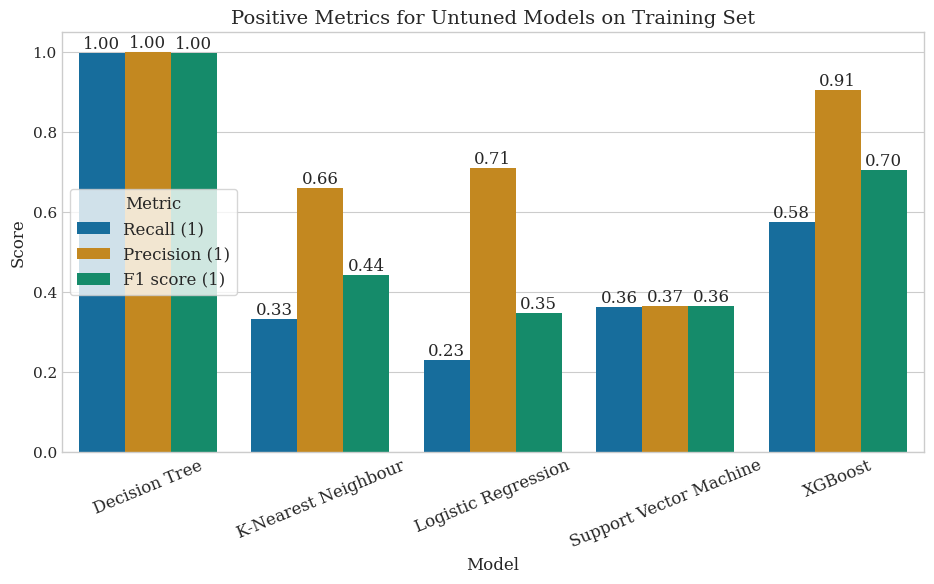

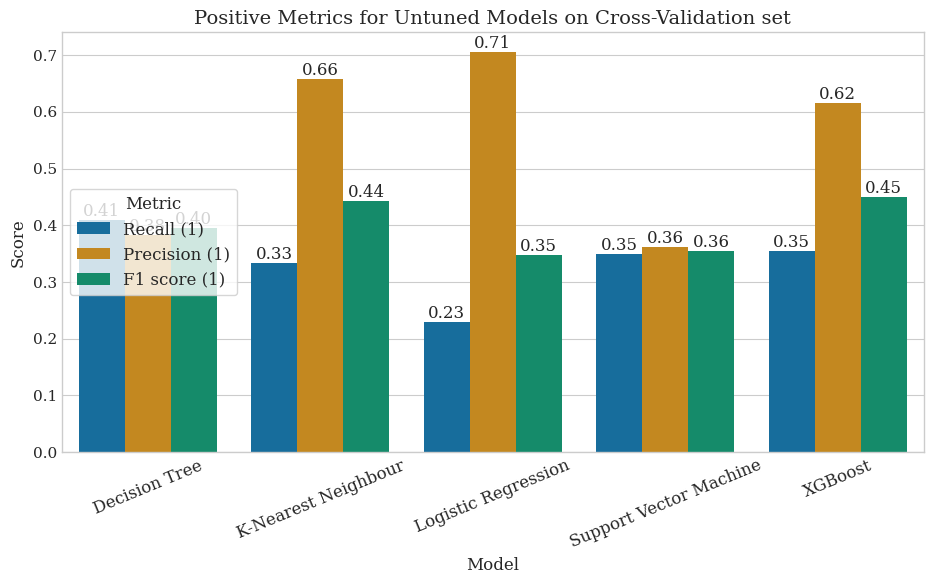

In [ ]:
'''models = {
    "Decision Tree": tree,
    "Logistic Regression":log_reg,
    "Support Vector Machine":svm,
    "K-Nearest Neighbour":knn,
    "XGBoost":xgb    
    }

plot_positive_class_metric(
    models=models,
    X_true=X_train_with_engineering,
    y_true=y_train,
    save= True,
    title= "Positive Metrics for Untuned Models on Training Set"
    )

plot_positive_class_metric(
    models=models,
    X_true=X_train_with_engineering,
    y_true=y_train,
    save= True,
    cross_val=True,
    title= "Positive Metrics for Untuned Models on Cross-Validation set"
    )'''

In [ ]:
plot_auc(lr_best_clf, 'Logistic Regression', save= True)
plot_pr_auc(lr_best_clf, 'Logistic Regression',save= True)
plot_auc(tree_best_clf, 'Decision Tree Classifier',save= True)
plot_pr_auc(tree_best_clf, 'Decision Tree Classifier',save= True)
plot_auc(knn_best_clf, 'K-Nearest Neighbors',save= True)
plot_pr_auc(knn_best_clf, 'K-Nearest Neighbors',save= True)
plot_auc(svm_best_clf, 'Support Vector Machines',save= True)
plot_pr_auc(svm_best_clf, 'Support Vector Machines',save= True)
plot_auc(xgb_best_clf, 'XGBoost', save=True)
plot_pr_auc(xgb_best_clf, 'XGBoost',save= True)

In [6]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE
import pandas as pd

In [4]:
scaled_X_train_with_engineering = pd.read_csv("C:/Users/banji/creditCard_default_risk/data/scaled_X_train_engineering.csv")
X_test= pd.read_csv("C:/Users/banji/creditCard_default_risk/data/X_test.csv")

y_train= pd.read_csv("C:/Users/banji/creditCard_default_risk/data/y_train.csv").squeeze() # needed so as to convert to series
y_test = pd.read_csv("C:/Users/banji/creditCard_default_risk/data/y_test.csv").squeeze()

In [ ]:
# The scaled_X_train_engineering has leakage because we used the entire train set to 
# fit the scaler, since we want to do cross validation, we need to remember the steps and redo it
#  and we cant use it with the 

In [13]:
FunctionTransformer(perform_engineering)

,func,<function per...0020EEB3B1DA0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None
,inv_kw_args,None


In [ ]:
 Pipeline([
    FunctionTransformer()
])

In [23]:
from sklearn.pipeline import FunctionTransformer


In [25]:
engineering = FunctionTransformer(perform_engineering())

TypeError: perform_engineering() missing 1 required positional argument: 'data'

In [14]:
# sklearn and imbalanced-learn Pipeline Tutorial
# Complete guide with Minimum Viable Examples (MVE)

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# =============================================================================
# 1. BASIC SKLEARN PIPELINE - MVE
# =============================================================================

print("=== 1. BASIC SKLEARN PIPELINE ===")

# Create sample data
X, y = make_classification(n_samples=1000, n_features=4, n_redundant=0, 
                          n_informative=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Basic pipeline: Scale + Classify
basic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit and predict
basic_pipeline.fit(X_train, y_train)
y_pred = basic_pipeline.predict(X_test)

print(f"Basic Pipeline Accuracy: {basic_pipeline.score(X_test, y_test):.3f}")


=== 1. BASIC SKLEARN PIPELINE ===
Basic Pipeline Accuracy: 0.870


In [18]:

# =============================================================================
# 2. IMBALANCED DATASET - MVE
# =============================================================================

print("\n=== 2. IMBALANCED DATASET EXAMPLE ===")

# Create imbalanced dataset
X_imb, y_imb = make_classification(n_samples=1000, n_features=4, 
                                  weights=[0.9, 0.1], flip_y=0.01, random_state=42)
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.2, random_state=42)

print(f"Class distribution: {np.bincount(y_train_imb)}")

# Without resampling
pipeline_no_resample = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

pipeline_no_resample.fit(X_train_imb, y_train_imb)
y_pred_no_resample = pipeline_no_resample.predict(X_test_imb)

print("\nWithout resampling:")
print(f"Accuracy: {pipeline_no_resample.score(X_test_imb, y_test_imb):.3f}")
print(classification_report(y_test_imb, y_pred_no_resample))


=== 2. IMBALANCED DATASET EXAMPLE ===
Class distribution: [721  79]

Without resampling:
Accuracy: 0.915
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       174
           1       1.00      0.35      0.51        26

    accuracy                           0.92       200
   macro avg       0.96      0.67      0.73       200
weighted avg       0.92      0.92      0.90       200



In [17]:

# =============================================================================
# 3. IMBALANCED-LEARN PIPELINE - MVE
# =============================================================================

print("\n=== 3. IMBALANCED-LEARN PIPELINE ===")

# Pipeline with SMOTE oversampling
imb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

imb_pipeline.fit(X_train_imb, y_train_imb)
y_pred_smote = imb_pipeline.predict(X_test_imb)

print("With SMOTE resampling:")
print(f"Accuracy: {imb_pipeline.score(X_test_imb, y_test_imb):.3f}")
print("\nClassification Report:")
print(classification_report(y_test_imb, y_pred_smote))



=== 3. IMBALANCED-LEARN PIPELINE ===
With SMOTE resampling:
Accuracy: 0.910

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       174
           1       0.62      0.81      0.70        26

    accuracy                           0.91       200
   macro avg       0.79      0.87      0.82       200
weighted avg       0.92      0.91      0.91       200



In [19]:

# =============================================================================
# 4. DIFFERENT RESAMPLING STRATEGIES - MVE
# =============================================================================

print("\n=== 4. DIFFERENT RESAMPLING STRATEGIES ===")

# Dictionary of different samplers
samplers = {
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

results = {}

for name, sampler in samplers.items():
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('sampler', sampler),
        ('classifier', LogisticRegression(random_state=42))
    ])
    
    pipeline.fit(X_train_imb, y_train_imb)
    accuracy = pipeline.score(X_test_imb, y_test_imb)
    results[name] = accuracy
    print(f"{name}: {accuracy:.3f}")



=== 4. DIFFERENT RESAMPLING STRATEGIES ===
RandomOverSampler: 0.910
SMOTE: 0.910
RandomUnderSampler: 0.910
SMOTEENN: 0.900


In [20]:

# =============================================================================
# 5. REAL-WORLD EXAMPLE WITH PANDAS - MVE
# =============================================================================

print("\n=== 5. REAL-WORLD EXAMPLE WITH PANDAS ===")

# Create a more realistic dataset
np.random.seed(42)
n_samples = 1000

# Generate features
age = np.random.randint(18, 80, n_samples)
income = np.random.normal(50000, 20000, n_samples)
credit_score = np.random.randint(300, 850, n_samples)
existing_loans = np.random.poisson(2, n_samples)

# Create imbalanced target (loan approval)
# Higher income and credit score = higher approval probability
prob = 1 / (1 + np.exp(-((income/50000 + credit_score/700) - 1.5)))
loan_approved = np.random.binomial(1, prob * 0.3)  # Making it imbalanced

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'credit_score': credit_score,
    'existing_loans': existing_loans,
    'loan_approved': loan_approved
})

print(f"Dataset shape: {df.shape}")
print(f"Class distribution: {df['loan_approved'].value_counts().to_dict()}")

# Prepare features and target
X_real = df[['age', 'income', 'credit_score', 'existing_loans']]
y_real = df['loan_approved']

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real)

# Complete pipeline with feature scaling and SMOTE
complete_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

complete_pipeline.fit(X_train_real, y_train_real)
y_pred_real = complete_pipeline.predict(X_test_real)

print("\nComplete Pipeline Results:")
print(f"Accuracy: {complete_pipeline.score(X_test_real, y_test_real):.3f}")
print("\nClassification Report:")
print(classification_report(y_test_real, y_pred_real))



=== 5. REAL-WORLD EXAMPLE WITH PANDAS ===
Dataset shape: (1000, 5)
Class distribution: {0: 836, 1: 164}

Complete Pipeline Results:
Accuracy: 0.755

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       167
           1       0.23      0.21      0.22        33

    accuracy                           0.76       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.75      0.76      0.75       200



In [21]:

# =============================================================================
# 6. CROSS-VALIDATION WITH PIPELINES - MVE
# =============================================================================

print("\n=== 6. CROSS-VALIDATION WITH PIPELINES ===")

# Cross-validation with imbalanced pipeline
cv_scores = cross_val_score(complete_pipeline, X_train_real, y_train_real, 
                           cv=5, scoring='f1')

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")



=== 6. CROSS-VALIDATION WITH PIPELINES ===
Cross-validation F1 scores: [0.21428571 0.08333333 0.21818182 0.22222222 0.18181818]
Mean F1 score: 0.184 (+/- 0.105)


In [22]:
# MVE: Custom Preprocessing Functions in Pipelines
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Sample data
X = pd.DataFrame({
    'age': [25, 35, np.nan, 45, 55],
    'income': [30000, 50000, 80000, 60000, 90000],
    'category': ['A', 'B', 'A', 'C', 'B']
})
y = [0, 1, 1, 0, 1]


In [ ]:

# Your existing preprocessing functions
def fill_missing(df):
    return df.fillna(df.mean())

def create_features(df):
    df = df.copy()
    df['income_per_age'] = df['income'] / df['age']
    return df

def encode_cats(df):
    return pd.get_dummies(df, drop_first=True)

# Method 1: Simple FunctionTransformer
pipeline1 = Pipeline([
    ('fill', FunctionTransformer(fill_missing)),
    ('features', FunctionTransformer(create_features)),
    ('encode', FunctionTransformer(encode_cats)),
    ('model', RandomForestClassifier(n_estimators=10, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
pipeline1.fit(X_train, y_train)
print(f"Simple pipeline accuracy: {pipeline1.score(X_test, y_test):.2f}")

# Method 2: Custom transformer class (when you need to learn from training data)
from sklearn.base import BaseEstimator, TransformerMixin

class SmartFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.fill_values = X.mean()  # Learn from training data
        return self
    
    def transform(self, X):
        return X.fillna(self.fill_values)

pipeline2 = Pipeline([
    ('smart_fill', SmartFiller()),
    ('features', FunctionTransformer(create_features)),
    ('encode', FunctionTransformer(encode_cats)),
    ('model', RandomForestClassifier(n_estimators=10, random_state=42))
])

pipeline2.fit(X_train, y_train)
print(f"Smart pipeline accuracy: {pipeline2.score(X_test, y_test):.2f}")

# Method 3: Multiple functions in one transformer
def preprocess_all(df):
    df = fill_missing(df)
    df = create_features(df) 
    df = encode_cats(df)
    return df

pipeline3 = Pipeline([
    ('preprocess', FunctionTransformer(preprocess_all)),
    ('model', RandomForestClassifier(n_estimators=10, random_state=42))
])

pipeline3.fit(X_train, y_train)
print(f"Combined pipeline accuracy: {pipeline3.score(X_test, y_test):.2f}")

print("Done! Choose the method that fits your needs.")

In [ ]:
# Feature engineering --> append continuous column -->  Drop correlated features 
# Feature engineering
def feature_transformation_pipeline(data, continuous_columns): #=X_train
    feature_engineering = perform_engineering(data)
    data_with_engineering = feature_engineering[0]
    added_continuous_columns = feature_engineering[1]

# Append continous column name
    continuous_columns = add_continuous_columns(continuous_columns, added_continuous_columns)

# drop correlated features, as you drop correlated features, you need to return it 
    transformed_data= drop_correlated_features(data_with_engineering)[0]
    dropped_columns= drop_correlated_features(data_with_engineering)[1]
    continuous_columns = [col for col in continuous_columns if col not in dropped_columns]
    return transformed_data, continuous_columns

def pipeline_transformation(data, continuous_columns):
    # wrapping this function so that we can use it for Function Transformer
    # fucntions for pipeline must always return X: X_in and X_out
    transformed_data, _ = feature_transformation_pipeline(data, continuous_columns)
    return transformed_data